In [11]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [15]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.

        Вычисляет выход, используя текущий набор параметров класса и входные данные.
        Функция возвращает результат, который хранится в поле `output`.

        Убедитесь, что данные хранятся в поле `output` и возвращаются.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.

        Вычисление градиента модуля по отношению к его собственному входу.
        Это значение возвращается в `gradInput`. Также соответствующим образом обновляется переменная состояния `gradInput`.

        Форма `gradInput` всегда такая же, как и форма `input`.

        Убедитесь, что градиенты как хранятся в поле `gradInput`, так и возвращаются.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).

        Вычисление градиента модуля относительно его собственных параметров.
        Не нужно переопределять, если у модуля нет параметров (например, ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [296]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
        self.y = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        self.y = []
        self.y.append(input)
        for i in range(len(self.modules)):
            self.y.append(self.modules[i].forward(self.y[i]))

        self.output = self.y[-1] 
        
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        g = [None] * len(self.modules)
        g.append(gradOutput) # <--- gradOutput - это g_n
        for i in range(len(self.modules) - 1, -1, -1):
            g[i] = self.modules[i].backward(self.y[i], g[i+1])

        self.gradInput = g[0]

            
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [17]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).

    Модуль, применяющий линейное преобразование.
    Общее название - полностью связанный слой, InnerProductLayer в caffe.

    Модуль должен работать с 2D входными данными формы (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization  
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in)) #иницилизация весов
        self.b = np.random.uniform(-stdv, stdv, size = n_out) #иницилизация смещения

        self.gradW = np.zeros_like(self.W) #иницилизация градиента весов
        self.gradb = np.zeros_like(self.b) #иницилизация градиента смещений

    def updateOutput(self, input): #выход слоя
        # Your code goes here. ################################################
        self.output = np.dot(input, self.W.T) + self.b #y=X*W.T+b
        return self.output

    def updateGradInput(self, input, gradOutput): #градиент входа, цепное правило
        # Your code goes here. ################################################
        self.gradInput = np.dot(gradOutput, self.W) #GradInput=gradOutput*W
        return self.gradInput

    def accGradParameters(self, input, gradOutput): #накапливает градиенты весов и смещений
        # Your code goes here. ################################################
        self.gradW = np.dot(gradOutput.T, input); 
        self.gradb = np.sum(gradOutput, axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [145]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True)) #- макс значение
        
        # Your code goes here. ################################################
        exp_values = np.exp(self.output)
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = self.output * (gradOutput - np.sum(gradOutput * self.output, axis=1, keepdims=True))
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [379]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = self.output - np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        softmax = np.exp(input - input.max(axis=1, keepdims=True)) / np.sum(np.exp(input - input.max(axis=1, keepdims=True)), axis=1, keepdims=True)
        self.gradInput = gradOutput - softmax * np.sum(gradOutput, axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

$$
\begin{aligned}
gradInput = & \frac{gradOutput}{\sqrt{\sigma^2 + \epsilon}} - \frac{1}{m} \sum_{i=1}^{m} \frac{gradOutput_i}{\sqrt{\sigma^2 + \epsilon}} - \frac{x - \mu}{(\sigma^2 + \epsilon)^{3/2}} \cdot \frac{\sum_{i=1}^{m} gradOutput_i \cdot (x_i - \mu)}{m}
\end{aligned}
$$

In [45]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training == True:
            batch_mean = np.mean(input, axis=0)
            batch_variance = np.var(input, axis=0)

            if self.moving_mean is None:
                self.moving_mean = batch_mean
                self.moving_variance = batch_variance
            else:
                self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
                self.moving_variance = self.moving_variance * self.alpha + batch_variance * (1 - self.alpha)

            self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training == True:
            batch_mean = np.mean(input, axis=0)
            batch_variance = np.var(input, axis=0)
            self.gradInput = gradOutput * (batch_variance + self.EPS)**(-0.5) - \
                               np.mean(gradOutput * (batch_variance + self.EPS)**(-0.5), axis=0) - \
                               (input - batch_mean) * (batch_variance + self.EPS)**(-1.5) * np.mean(gradOutput * (input - batch_mean), axis=0)
        else:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [164]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = gamma * x + beta
       where gamma, beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [178]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training == True:
            self.mask = np.random.binomial(1, 1 - self.p, size=input.shape) #матрица из 0 и 1
            self.output = input * self.mask / (1 - self.p)
        else:
            self.output = input
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training == True:
            self.gradInput = gradOutput * self.mask / (1 - self.p)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

# 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [ ]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.padding_mode = padding_mode

    def updateOutput(self, input):
        # Your code goes here. ################################################
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        return self.gradInput

    def __repr__(self):
        return "Conv2d"

## 7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). 
Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [204]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        N, C, H_in, W_in = input.shape
        H_out = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1

        self.output = np.zeros((N, C, H_out, W_out))
        self.indices = np.zeros((N, C, H_out, W_out), dtype=int)  

        if self.padding != 0:
            input_padded = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=np.NINF)
            #padding: заполняем -inf, тк 0 могут быть ложно выбраны как максимум
        else:
            input_padded = input

        for i in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        receptive_field = input_padded[i, c, h_start:h_end, w_start:w_end] #размер рецептивного поля
                        max_val = np.max(receptive_field)        #берем из него максимум                
                        self.output[i, c, h, w] = max_val     #и ставим максимум на место в output
                        self.indices[i, c, h, w] = np.argmax(receptive_field)  #сохраняем индекс макимального значения для обратного прохода
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H_in, W_in = input.shape
        H_out = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1

        self.gradInput = np.zeros_like(input)

        if self.padding != 0:
            input_padded = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=np.NINF)
            grad_input_padded = np.pad(self.gradInput, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=0)
        else:
            input_padded = input
            grad_input_padded = self.gradInput
            
        for i in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        index = self.indices[i, c, h, w]
                        
                        row_index = index // self.kernel_size
                        col_index = index % self.kernel_size

                        grad_input_padded[i, c, h_start + row_index, w_start + col_index] += gradOutput[i, c, h, w]

        if self.padding != 0:
            self.gradInput = grad_input_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            self.gradInput = grad_input_padded
        return self.gradInput


    def __repr__(self):
        return "MaxPool2d"

In [193]:
class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        N, C, H_in, W_in = input.shape
        H_out = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1

        self.output = np.zeros((N, C, H_out, W_out))

        if self.padding != 0:
            input_padded = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=0)
            #здесь padding заполняем 0
        else:
            input_padded = input

        for i in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        receptive_field = input_padded[i, c, h_start:h_end, w_start:w_end]
                        self.output[i, c, h, w] = np.mean(receptive_field)
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H_in, W_in = input.shape
        H_out = (H_in + 2 * self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2 * self.padding - self.kernel_size) // self.stride + 1

        self.gradInput = np.zeros_like(input)

        if self.padding != 0:
            grad_input_padded = np.pad(self.gradInput, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=0)
        else:
            grad_input_padded = self.gradInput

        for i in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        grad_value = gradOutput[i, c, h, w] / (self.kernel_size * self.kernel_size)  
                        for h_in in range(h_start, h_end):
                            for w_in in range(w_start, w_end):
                                grad_input_padded[i, c, h_in, w_in] += grad_value

        if self.padding != 0:
            self.gradInput = grad_input_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            self.gradInput = grad_input_padded

        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

# 8. (0.3) 
Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [262]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def updateOutput(self, input):
        N, C, H_in, W_in = input.shape
        self.output = np.zeros((N, C), dtype=np.float32)

        for i in range(N):
            for c in range(C):
                self.output[i, c] = np.max(input[i, c, :, :])

        self.input_shape = input.shape
        self.input_tensor = input.astype(np.float32)
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H_in, W_in = self.input_shape
        self.gradInput = np.zeros_like(self.input_tensor, dtype=np.float32)

        for i in range(N):
            for c in range(C):
                max_index = np.argmax(self.input_tensor[i, c, :, :])
                max_h = max_index // W_in
                max_w = max_index % W_in
                self.gradInput[i, c, max_h, max_w] = gradOutput[i, c]

        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"

In [265]:
class GlobalAvgPool2d(Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def updateOutput(self, input):
        N, C, H_in, W_in = input.shape
        self.output = np.zeros((N, C), dtype=np.float32)

        for i in range(N):
            for c in range(C):
                self.output[i, c] = np.mean(input[i, c, :, :])

        self.input_shape = input.shape
        self.input_tensor = input.astype(np.float32)
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H_in, W_in = self.input_shape
        self.gradInput = np.zeros_like(self.input_tensor, dtype=np.float32)

        for i in range(N):
            for c in range(C):
                self.gradInput[i, c, :, :] = gradOutput[i, c] / (H_in * W_in)  

        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"

# 9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [249]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.original_shape = input.shape

        # Вычисляем новую форму, учитывая start_dim и end_dim
        new_shape = list(input.shape)
        start_dim = self.start_dim if self.start_dim >= 0 else len(new_shape) + self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else len(new_shape) + self.end_dim

        new_shape = new_shape[:start_dim] + [-1]
        if end_dim != -1:
            new_shape[start_dim] = np.prod(input.shape[start_dim:end_dim+1])

        self.output = input.reshape(*new_shape)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.original_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [ ]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [ ]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.slope * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [81]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input >= 0, input, self.alpha * (np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input >= 0, gradOutput, self.alpha * gradOutput * np.exp(input))                       
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [ ]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log(1 + np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * np.exp(input) / (1 + np.exp(input))
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# 13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.
$$
\text{GELU}(x) = 0.5x \cdot \left( 1 + \tanh \left( \sqrt{\frac{2}{\pi}} (x + 0.044715x^3) \right) \right)
$$

In [98]:
#в homework_test_modules понизила точность, так как формула приближенная
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        self.output = 0.5 * input * (1 + np.tanh(np.sqrt(2/np.pi) * (input + 0.044715 * input**3)))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        a = np.sqrt(2/np.pi) * (input + 0.044715 * input**3)
        
        self.gradInput = gradOutput * (0.5 + 0.5 * np.tanh(a) + 
    0.5 * input * ( (1 - (np.tanh(a))**2) * (np.sqrt(2/np.pi) + 3 * np.sqrt(2/np.pi) * 0.044715 * input**2) ) )
        
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [111]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [113]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [115]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.output = -np.sum(target * np.log(input_clamp)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        target = target.astype(np.int64)

        # Your code goes here. ################################################
        self.gradInput = -(target / input_clamp) / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [119]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = -np.sum(target * input) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = -target / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

## Оптимизатор: Adagrad

In [129]:
class Adagrad:
    def __init__(self, params, lr=1e-2, eps=1e-8):
        self.lr = lr
        self.eps = eps
        self.params = params
        self.G = [np.zeros_like(param) for param in self.params]


    def step(self, grads):
        for i, (param, grad) in enumerate(zip(self.params, grads)): 
            self.G[i] += grad**2 #накапливаем градиенты
            param -= self.lr * grad / (np.sqrt(self.G[i]) + self.eps) #обновляем параметры

    def zero_grad(self):
        for squared_grad in self.G: #обнуляем накопленные градиенты
            squared_grad[:] = 0
        return 'Adagrad'

In [131]:
# Пример использования:
params = [np.random.randn(5, 10), np.random.randn(10, 3)] # Ваши параметры (веса модели)
optimizer = Adagrad(params)

# Цикл обучения (пример)
for i in range(100):
    # Вычисляем градиенты (например, обратным распространением ошибки)
    grads = [np.random.randn(5, 10), np.random.randn(10, 3)] # Пример градиентов

    # Обновляем параметры
    optimizer.step(grads)

    # Обнуляем градиенты
    optimizer.zero_grad()

## Мультирегрессия

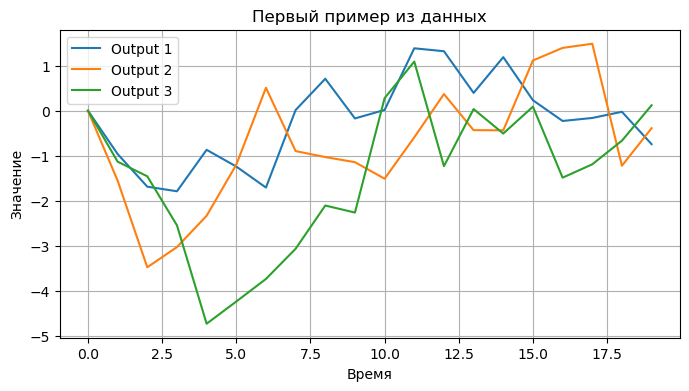

In [628]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(42)
num_samples = 1000 #количество наблюдений
num_outputs = 3 #количество выходных переменных
seq_length = 20 #длина последовательности временного ряда
#Пример: 1000 датчиков измеряют температуру, давление и влажность последовательно по 20 раз

# Матрица коэффициентов VAR(1) 
A = np.array([[0.5, 0.2, 0.1],
              [0.1, 0.6, 0.2],
              [0.2, 0.1, 0.7]])

# Ковариационная матрица ошибок 
Sigma = np.array([[1.0, 0.5, 0.3],
                  [0.5, 1.5, 0.2],
                  [0.3, 0.2, 1.2]])

# Генерация данных
data = np.zeros((num_samples, seq_length, num_outputs))
errors = np.random.multivariate_normal(mean=np.zeros(num_outputs), cov=Sigma, size=(num_samples, seq_length))
for i in range(num_samples):
    for t in range(1, seq_length):
        data[i, t] = A @ data[i, t-1] + errors[i, t]

# Визуализация данных
plt.figure(figsize=(8,4))
for i in range(num_outputs):
    plt.plot(data[0, :, i], label=f'Output {i+1}')
plt.title('Первый пример из данных') #20 измерений трех показателей с 1 датчика
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

In [630]:
X = data[:, :-1, :].reshape(num_samples, (seq_length - 1) * num_outputs)
y = data[:, -1, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [638]:
class FCNN(Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.0):
        super(FCNN, self).__init__()
        self.model = Sequential()
        self.linear1 = Linear(input_size, hidden_size)
        self.bn1 = BatchNormalization(hidden_size)
        self.relu1 = ReLU() 
        self.dropout1 = Dropout(dropout)
        self.linear2 = Linear(hidden_size, output_size)

    def updateOutput(self, input):
        self.output = self.linear1.updateOutput(input)
        self.output = self.bn1.updateOutput(self.output)
        self.output = self.relu1.updateOutput(self.output)
        self.output = self.dropout1.updateOutput(self.output)
        self.output = self.linear2.updateOutput(self.output)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = self.linear2.updateGradInput(self.linear1.output, gradOutput)
        self.gradInput = self.dropout1.updateGradInput(self.relu1.output, self.gradInput)
        self.gradInput = self.relu1.updateGradInput(self.bn1.output, self.gradInput)
        self.gradInput = self.bn1.updateGradInput(self.linear1.output, self.gradInput)
        self.gradInput = self.linear1.updateGradInput(input, self.gradInput)
        return self.gradInput
    def zeroGradParameters(self):
        self.linear1.zeroGradParameters()
        self.linear2.zeroGradParameters()
        self.bn1.zeroGradParameters()
    def getParameters(self):
        return self.linear1.getParameters() + self.linear2.getParameters() + self.bn1.getParameters()
    def getGradParameters(self):
        return self.linear1.getGradParameters() + self.linear2.getGradParameters() + self.bn1.getGradParameters()

In [654]:
def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.001, epochs=100, batch_size=32):
    criterion = MSECriterion()  
    optimizer = Adagrad(model.getParameters())
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            model.zeroGradParameters() 
            outputs = model.updateOutput(X_batch)
            loss = criterion.updateOutput(outputs, y_batch)
            grad_output = criterion.updateGradInput(outputs, y_batch)
            model.backward(X_batch, grad_output)
            optimizer.step()

        train_output = model.updateOutput(X_train)
        train_loss = criterion.updateOutput(train_output, y_train)
        train_losses.append(train_loss)

        test_output = model.updateOutput(X_test)
        test_loss = criterion.updateOutput(test_output, y_test)
        test_losses.append(test_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

input_size = (seq_length - 1) * num_outputs
output_size = num_outputs



In [656]:
model = FCNN(input_size, 64, output_size, dropout=0.2)
train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)

AttributeError: 'MSECriterion' object has no attribute 'updateOutput'

## Мультиклассификация на MNIST

In [540]:
import torchvision
from torchvision import transforms as T
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
    ]
)

train_dataset = torchvision.datasets.MNIST(
    'MNIST', train=True, download=True, transform=transform
)
val_dataset = torchvision.datasets.MNIST(
    'MNIST', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1024, shuffle=False, num_workers=4
)

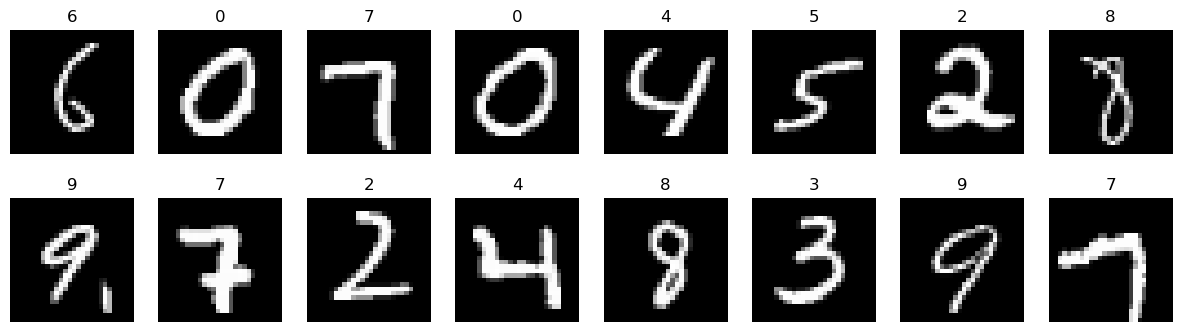

In [347]:
images, labels = next(iter(train_loader))
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(images[k], (1, 2, 0)), cmap='gray')
        ax.set_title(labels[k].item())
        k += 1
plt.show()

In [610]:
class MyNN(Module):
    def __init__(self, in_features, num_classes, hide_neurons):
        super(MyNN, self).__init__()
        self.model = Sequential()
        self.model.add(Linear(784, hide_neurons))
        self.model.add(ReLU())
        self.model.add(Linear(hide_neurons, hide_neurons // 2))
        self.model.add(ReLU())
        self.model.add(Linear(hide_neurons//2, hide_neurons//4))
        self.model.add(ReLU())
        self.model.add(Linear(hide_neurons//4, num_classes))
        #self.LogSoftMax = LogSoftMax()
        
        
    def forward(self, input):
        return self.model.forward(input)

    def backward(self, input, grad):
        return self.model.backward(input, grad)
        
    def getParameters(self):
        return self.model.getParameters()

model = MyNN(28**2, 10, 64)

In [612]:
from IPython.display import clear_output
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [614]:
def train():
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(torch.flatten(images, start_dim=1))
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(torch.flatten(images, start_dim=1))
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [624]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10

model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE) 
optimizer = Adagrad(model.getParameters())
scheduler = None
criterion = nn.CrossEntropyLoss()  # nn.NLLLoss()
train()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 64) + inhomogeneous part.